In [22]:
#load data
import matplotlib.pyplot as plt
import load_data as ld
import math
import numpy as np
import MapUtils as MU
from scipy.special import logsumexp

acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, imu_ts	 = ld.get_imu('data/imu23')

FR, FL, RR, RL,enc_ts = ld.get_encoder('data/Encoders23')

lidar = ld.get_lidar('data/Hokuyo23')

In [23]:
# Bresenham's ray tracing algorithm in 2D.
# Inputs:
#(sx, sy) start point of ray
#(ex, ey) end point of ray
def bresenham2D(sx, sy, ex, ey):
    sx = int(round(sx))
    sy = int(round(sy))
    ex = int(round(ex))
    ey = int(round(ey))
    dx = abs(ex-sx)
    dy = abs(ey-sy)
    steep = abs(dy)>abs(dx)
    if steep:
        dx,dy = dy,dx # swap 
        
    if dy == 0:
        q = np.zeros((dx+1,1))
    else:
        q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
        
    if steep:
        if sy <= ey:
            y = np.arange(sy,ey+1)
        else:
            y = np.arange(sy,ey-1,-1)
        if sx <= ex:
            x = sx + np.cumsum(q)
        else:
            x = sx - np.cumsum(q)
    else:
        if sx <= ex:
            x = np.arange(sx,ex+1)
        else:
            x = np.arange(sx,ex-1,-1)
        if sy <= ey:
            y = sy + np.cumsum(q)
        else:
            y = sy - np.cumsum(q)
    return np.vstack((x,y))

In [24]:
#use encoder data to get robot's path - odometry only
#width = (0.47625+0.31115)/2 #from platform_config.pdf (units in m)
width = 0.7
radius = (0.5842-0.3302)/2 #from platform_config.pdf
outer = (FR+RR)/2 #outer = right wheels
inner = (FL+RL)/2 #inner = left wheels
dr = 2*math.pi*radius*(outer/360) #360 encoder counts/revolution from platform_config.pdf
dl = 2*math.pi*radius*(inner/360)

Text(0.5, 1.0, 'Robot Path')

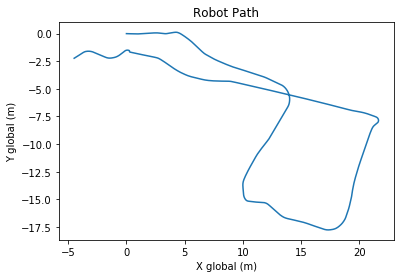

In [25]:
#plot robot trajectory - odometry only
theta_global = np.zeros(dl.shape)
X_global = np.zeros(dl.shape)
Y_global = np.zeros(dl.shape)
dist = np.zeros(dl.shape)

total_dist = np.zeros(dl.shape)

for i in range(1,len(dist)):
    theta_global[i] = theta_global[i-1] + ((dr[i]-dl[i])/width)
    X_global[i] = X_global[i-1] + ((dr[i]+dl[i])/2)*np.cos(theta_global[i])
    Y_global[i] = Y_global[i-1] + ((dr[i]+dl[i])/2)*np.sin(theta_global[i])
    dist[i] = dist[i-1] = (dr[i]+dl[i])/2
plt.plot(X_global,Y_global)
plt.xlabel('X global (m)')
plt.ylabel('Y global (m)')
plt.title('Robot Path')

In [26]:
#set up map initializations
MAP = {}
MAP['res'] = 0.05 #meters
MAP['xmin'] = -30 #meters, change if needed
MAP['ymin'] = -30 #change if needed
MAP['xmax'] = 30 #change if needed
MAP['ymax'] = 30 #change if needed
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64)


#merge timestamps of lidar data to encoder data
ind_lidar = np.zeros(dl.shape)
for i in range(len(dl)):
    d = 10
    for j in range(len(lidar)):
        if abs(enc_ts[i]-lidar[j]['t']) < d:
            d = abs(enc_ts[i]-lidar[j]['t'])
            ind_lidar[i] = j

Text(0.5, 1.0, 'Map')

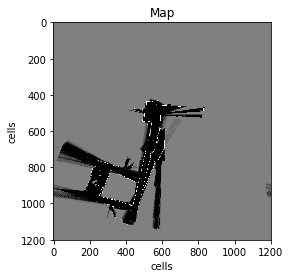

In [27]:
#theta and range information from lidar, merged with encoder timestamps
theta_lidar = lidar[0]['angle'] #same for all time samples
X_lidar = np.zeros((len(ind_lidar),len(lidar[0]['scan'])))
Y_lidar = np.zeros((len(ind_lidar),len(lidar[0]['scan'])))
ranges_lidar = np.zeros((len(ind_lidar),len(lidar[0]['scan'])))
for i in range(0,len(ind_lidar)):
    ranges_lidar[i,:] = lidar[int(ind_lidar[i])]['scan']

#x,y position from lidar relative to robot in m - converted to global x,y
for i in range(len(dist)):
    x = ranges_lidar[i]*(np.cos(theta_lidar)).flatten()
    y = ranges_lidar[i]*(np.sin(theta_lidar)).flatten()
    x_transformed = x*np.cos(theta_global[i]) - y*np.sin(theta_global[i])
    y_transformed = x*np.sin(theta_global[i]) + y*np.cos(theta_global[i])
    X_lidar[i,:] = X_global[i] + x_transformed
    Y_lidar[i,:] = Y_global[i] + y_transformed
    
#convert from global x,y in meters to map cells
X_map = np.ceil((X_lidar- MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
Y_map = np.ceil((Y_lidar - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

X_robot = np.ceil((X_global- MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
Y_robot = np.ceil((Y_global - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

max_hit = 30
min_hit = -30
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64)
for j in range(X_map.shape[0]):
    for i in range(X_map.shape[1]):
        #account for out of bounds map readings from new noise
        if (X_map[j,i] >=1201):
            X_map[j,i] = 1200
        if (X_map[j,i] <= -1202):
            X_map[j,i] = -1201
        if (Y_map[j,i] >= 1201):
            Y_map[j,i] = 1200
        if (Y_map[j,i] <= -1202):
            Y_map[j,i] = -1201
        MAP['map'][X_map[j,i]][Y_map[j,i]] = MAP['map'][X_map[j,i]][Y_map[j,i]] + 0.9 #hits
        if MAP['map'][X_map[j,i]][Y_map[j,i]] > 30:
            MAP['map'][X_map[j,i]][Y_map[j,i]] = 30
        misses = bresenham2D(X_robot[j],Y_robot[j],X_map[j,i],Y_map[j,i])
        for k in range(misses.shape[1]-1):
            #account for out of bounds map readings from new noise
            if (misses[0,k] >=1201):
                misses[0,k] = 1200
            if (misses[0,k] <= -1202):
                misses[0,k] = -1201
            if (misses[1,k] >= 1201):
                misses[1,k] = 1200
            if (misses[1,k] <= -1202):
                misses[1,k] = -1201
            MAP['map'][int(misses[0,k])][int(misses[1,k])] = MAP['map'][int(misses[0,k])][int(misses[1,k])] - 0.7 #misses
            if MAP['map'][int(misses[0,k])][int(misses[1,k])] < -30:
                MAP['map'][int(misses[0,k])][int(misses[1,k])] = -30
plt.imshow(MAP['map'],cmap='gray')
plt.ylabel('cells')
plt.xlabel('cells')
plt.title('Map')

Text(0.5, 1.0, 'Map with Robot Path')

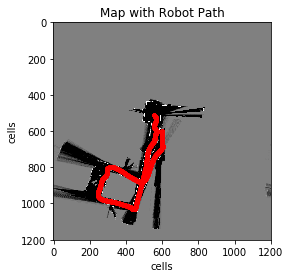

In [28]:
#add robot's path:
plt.imshow(MAP['map'],cmap='gray')
plt.scatter(Y_robot,X_robot,color='r',marker='.')
plt.ylabel('cells')
plt.xlabel('cells')
plt.title('Map with Robot Path')

Text(0.5, 1.0, 'Map with SLAM')

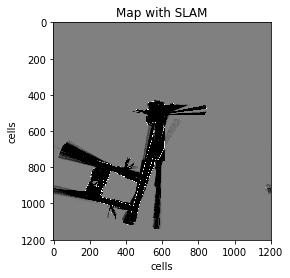

In [29]:
#SLAM portion
   
N = 70 #number of particles
weights_initial = math.log(1/N)
P = np.full(N, weights_initial) #particle weights, w each particle corresponding to a particular index

#initialize encoder readings
outer = (FR+RR)/2 #outer = right wheels
inner = (FL+RL)/2 #inner = left wheels

#initialize robot theta global, x and y global, lidar x,y global
theta_global = np.zeros((outer.shape[0],N))
X_global = np.zeros((outer.shape[0],N))
Y_global = np.zeros((outer.shape[0],N))

#initialize map
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64)

for x in range(0,len(outer)): #iterate through each time sample
    #gaussian distributed noise to be added to each non-zero encoder reading for particle filtering
    noise = np.random.normal(scale=0.0001,size=N)
    if (outer[x] > 0):
        dr = (2*math.pi*radius*((outer[x]+noise)/360))
    else:
        dr = np.zeros(N)
        
    if (inner[x] > 0):
        dl = (2*math.pi*radius*((inner[x]+noise)/360))
    else:
        dl = np.zeros(N)
        
    #calculate robot theta global, x global, y global, and distance for all particles for one time sample
    if (x > 0):
        theta_global[x,:] = theta_global[x-1,:] + ((dr-dl)/width)
        X_global[x,:] = X_global[x-1,:] + ((dr+dl)/2)*np.cos(theta_global[x,:])
        Y_global[x,:] = Y_global[x-1,:] + ((dr+dl)/2)*np.sin(theta_global[x,:])
        
    #global conversion in m for one time sample for all particles
    x_init = ranges_lidar[x]*(np.cos(theta_lidar)).flatten() 
    y_init = ranges_lidar[x]*(np.sin(theta_lidar)).flatten()

    X_lidar = np.zeros((N,len(ranges_lidar[0]))) #X,Y_lidar = global lidar hits for one time sample for all particles
    Y_lidar = np.zeros((N,len(ranges_lidar[0])))
    for z in range(0,N):
        X_lidar[z,:] = X_global[x,z] + (x_init*np.cos(theta_global[x,z]) - y_init*np.sin(theta_global[x,z]))
        Y_lidar[z,:] = Y_global[x,z] + (x_init*np.sin(theta_global[x,z]) + y_init*np.cos(theta_global[x,z]))
    
    #convert lidar hits from global x,y in meters to map cells for one time sample for all particles
    X_map = np.ceil((X_lidar- MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    Y_map = np.ceil((Y_lidar - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    #convert global robot x,y location in meters to map cells for one time sample for all particles
    X_robot = np.ceil((X_global[x]- MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    Y_robot = np.ceil((Y_global[x] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    #for initial map reading, all particles start at same pose, weighted equally
    if (x == 0):
        #occupancy grid mapping
        for i in range(X_map.shape[1]):
            MAP['map'][X_map[0,i]][Y_map[0,i]] = MAP['map'][X_map[0,i]][Y_map[0,i]] + 0.9 #hits
            if MAP['map'][X_map[0,i]][Y_map[0,i]] > 30:
                MAP['map'][X_map[0,i]][Y_map[0,i]] = 30
            misses = bresenham2D(X_robot[0],Y_robot[0],X_map[0,i],Y_map[0,i])
            for k in range(misses.shape[1]-1):
                 #account for out of bounds map readings from new noise
                if (misses[0,k] >=1201):
                    misses[0,k] = 1200
                if (misses[0,k] <= -1202):
                    misses[0,k] = -1201
                if (misses[1,k] >= 1201):
                    misses[1,k] = 1200
                if (misses[1,k] <= -1202):
                    misses[1,k] = -1201
                MAP['map'][int(misses[0,k])][int(misses[1,k])] = MAP['map'][int(misses[0,k])][int(misses[1,k])] - 0.7 #misses
                if MAP['map'][int(misses[0,k])][int(misses[1,k])] < -30:
                    MAP['map'][int(misses[0,k])][int(misses[1,k])] = -30
    else:
        
        #update correlation = sum of log-odds at lidar hits for each particle
        for w in range(0,N):
            correlation = 0
            for l in range(0,len((ranges_lidar[0]))):
                #account for out of bounds map readings from new noise
                if (X_map[w,l] >=1201):
                    X_map[w,l] = 1200
                if (X_map[w,l] <= -1202):
                    X_map[w,l] = -1201
                if (Y_map[w,l] >= 1201):
                    Y_map[w,l] = 1200
                if (Y_map[w,l] <= -1202):
                    Y_map[w,l] = -1201
                correlation = correlation + MAP['map'][X_map[w,l]][Y_map[w,l]]
            #add correlation to current logweight of each particle
            P[w] = P[w] + correlation
        #normalize weights, find best (highest weighted) particle to update map
        bestParticleIndex = 0
        bestParticleWeight = 0
        normFactor = logsumexp(P)
        for i in range(0,N):
            P[i] = P[i] - normFactor
            if math.exp(P[i]) > bestParticleWeight:
                bestParticleWeight = math.exp(P[i])
                bestParticleIndex = i

                
        #update map w occupancy grid mapping based on best particle
        for i in range(X_map.shape[1]):
            MAP['map'][X_map[bestParticleIndex,i]][Y_map[bestParticleIndex,i]] = MAP['map'][X_map[bestParticleIndex,i]][Y_map[bestParticleIndex,i]] + 0.9 #hits
            if MAP['map'][X_map[bestParticleIndex,i]][Y_map[bestParticleIndex,i]] > 30:
                MAP['map'][X_map[bestParticleIndex,i]][Y_map[bestParticleIndex,i]] = 30
            misses = bresenham2D(X_robot[bestParticleIndex],Y_robot[bestParticleIndex],X_map[bestParticleIndex,i],Y_map[bestParticleIndex,i])
            for k in range(misses.shape[1]-1):
                #account for out of bounds map readings from new noise
                if (misses[0,k] >=1201):
                    misses[0,k] = 1200
                if (misses[0,k] <= -1202):
                    misses[0,k] = -1201
                if (misses[1,k] >= 1201):
                    misses[1,k] = 1200
                if (misses[1,k] <= -1202):
                    misses[1,k] = -1201
                MAP['map'][int(misses[0,k])][int(misses[1,k])] = MAP['map'][int(misses[0,k])][int(misses[1,k])] - 0.7 #misses
                if MAP['map'][int(misses[0,k])][int(misses[1,k])] < -30:
                    MAP['map'][int(misses[0,k])][int(misses[1,k])] = -30
        
        #resample if necessary
        num = 0
        den = 0
        for i in range(0,N):
            num = num + math.exp(P[i])
            den = den+((math.exp(P[i]))*(math.exp(P[i])))
        num = (num*num)
        nEff = num/den
        if nEff < 30: #resample if effective number of particles falls below 30
            cumulativeSum = np.zeros(N)
            sumVal = 0
            for i in range(0,N):
                sumVal = sumVal + math.exp(P[i])
                cumulativeSum[i] = sumVal
            #resample, update pose and weights
            new_P = np.zeros(N)
            new_theta_global = np.zeros(N)
            new_X_global = np.zeros(N)
            new_Y_global = np.zeros(N)
            for j in range(0,N):
                sample = np.random.uniform()
                index = 0
                while (cumulativeSum[index]<sample and index < N-1):
                    index = index + 1
                new_P[j] = P[index]
                new_theta_global[j] = theta_global[x,index]
                new_X_global[j] = X_global[x,index]
                new_Y_global[j] = Y_global[x,index]
            P = np.copy(new_P)
            theta_global[x,:] = new_theta_global
            X_global[x,:] = new_X_global
            Y_global[x,:] = new_Y_global
            #renormalize weights
            normFactor = logsumexp(P)
            for i in range(0,N):
                P[i] = P[i] - normFactor
#plot map
plt.imshow(MAP['map'],cmap='gray')
plt.ylabel('cells')
plt.xlabel('cells')
plt.title('Map with SLAM')

Text(0.5, 1.0, 'Robot Path with SLAM')

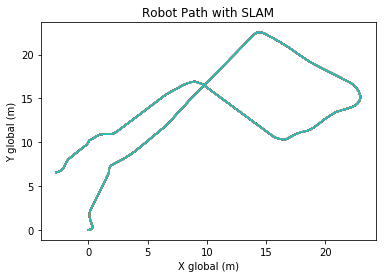

In [21]:
plt.plot(X_global,Y_global)
plt.xlabel('X global (m)')
plt.ylabel('Y global (m)')
plt.title('Robot Path with SLAM')